In [10]:
import scanpy as sc
import os
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import pandas as pd

In [2]:
scGPT = sc.read_h5ad("./data/scGPT_neftel_ss2.h5ad")
scGPT_cancer = sc.read_h5ad("./data/scGPT_cancer_neftel_ss2.h5ad")
CancerGPT = sc.read_h5ad("./data/CancerGPT_neftel_ss2.h5ad")

adata = CancerGPT
adata.obsm["scGPT"] = scGPT.obsm["X_scGPT"]
adata.obsm["scGPT (cancer)"] = scGPT_cancer.obsm["X_scGPT"]

In [9]:
CancerGPT

AnnData object with n_obs × n_vars = 4338 × 1199
    obs: 'sample', 'age_group', 'cell_type', 'cross_section', 'genes_expressed', 'subclone', 'MESlike2', 'MESlike1', 'AClike', 'OPClike', 'NPClike1', 'NPClike2', 'G1S', 'G2M', 'tSNE1', 'tSNE2', 'malignant', 'complexity', 'technology', 'n_cells', 'patient', 'cancer_type', 'sex', 'age', 'smoking_status', 'PY', 'diagnosis_recurrence', 'disease_extent', 'AJCC_T', 'AJCC_N', 'AJCC_M', 'AJCC_stage', 'sample_primary_met', 'size', 'site', 'histology', 'genetic_hormonal_features', 'grade', 'KI67', 'treated_naive', 'chemotherapy_exposed', 'chemotherapy_response', 'targeted_rx_exposed', 'targeted_rx_response', 'ICB_exposed', 'ICB_response', 'ET_exposed', 'ET_response', 'time_end_of_rx_to_sampling', 'post_sampling_rx_exposed', 'post_sampling_rx_response', 'PFS_DFS', 'OS', 'n_genes', 'MESlike', 'NPClike', 'Subtype', 'subtype', 'study', 'str_batch', 'S_score', 'G2M_score', 'phase'
    var: 'genes', 'id_in_vocab', 'highly_variable', 'means', 'dispersion

In [11]:
for key in ['CancerGPT', 'scGPT', 'scGPT (cancer)']:
    pd.DataFrame(adata.obsm[key], index=adata.obs_names).to_csv(f"{key.replace(' ', '_')}.csv")

In [8]:
sc.read_h5ad("data/neftel_ss2.h5ad").obs["subtype"].value_counts()

subtype
AClike     1343
MESlike    1227
NPClike    1155
OPClike     613
Name: count, dtype: int64

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


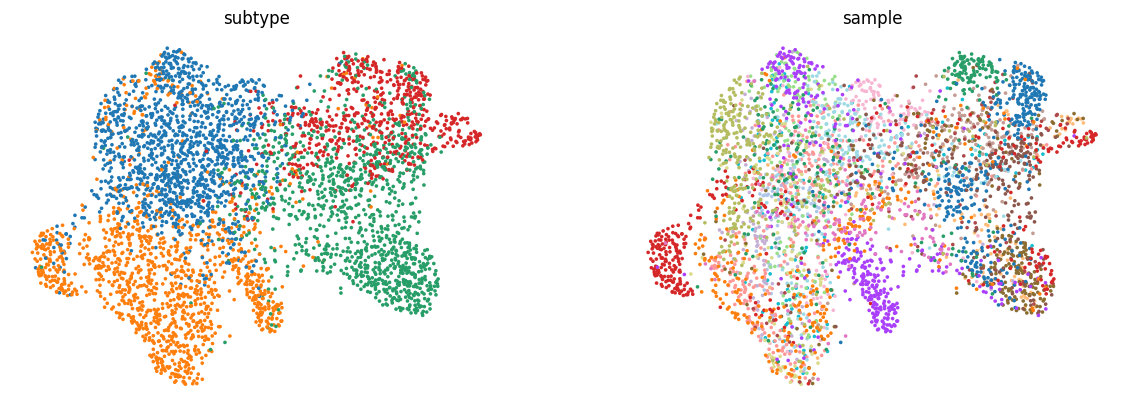

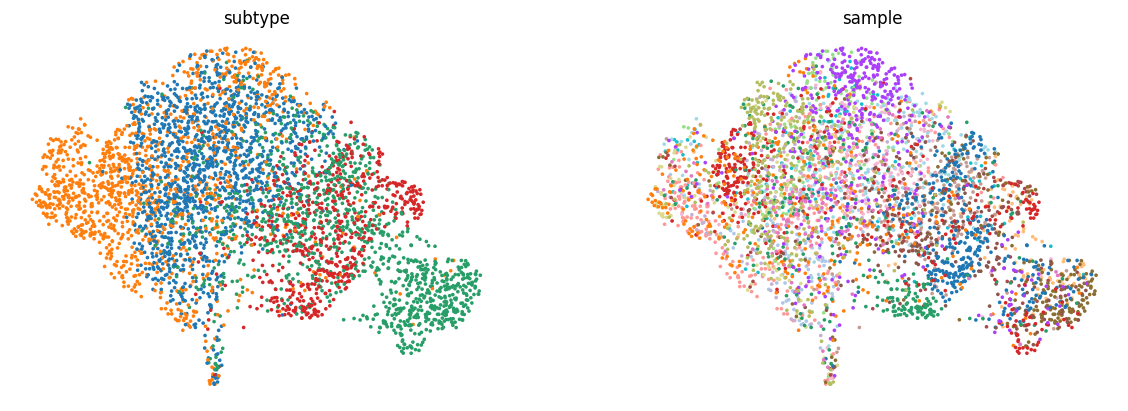

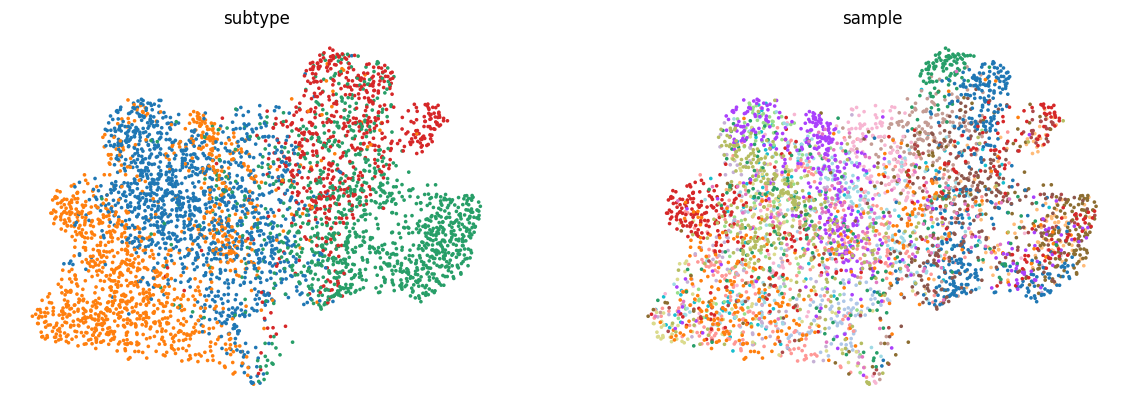

In [3]:
## Generate plots
os.makedirs("./figures", exist_ok=True)
for rep in ["CancerGPT", "scGPT", "scGPT (cancer)"]:
    sc.pp.neighbors(adata, use_rep=rep)
    sc.tl.umap(adata)
    fig = sc.pl.umap(adata, 
            color=["subtype", "sample"], 
            frameon=False, 
            palette=sc.pl.palettes.default_20,
            legend_loc=None,
            return_fig=True)
    fig.savefig(f"figures/{rep}_umap.png", dpi=300, bbox_inches="tight")

In [ ]:
# results may vary slightly given differnet seeds
bio_conservation = BioConservation(nmi_ari_cluster_labels_kmeans=False, nmi_ari_cluster_labels_leiden=True)
batch_correction = BatchCorrection(pcr_comparison=False)

bm = Benchmarker(
    adata,
    batch_key="sample",
    label_key="subtype",
    embedding_obsm_keys=["CancerGPT", "scGPT", "scGPT (cancer)"],
    n_jobs=6,
    bio_conservation_metrics = bio_conservation,
    batch_correction_metrics=batch_correction,
)
bm.benchmark()

/home/alexander/miniconda3/envs/cancergpt/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]WARNING:jax._src.xla_bridge:An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/alexander/miniconda3/envs/cancergpt/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/alexander/miniconda3/envs/cancergpt/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future versi

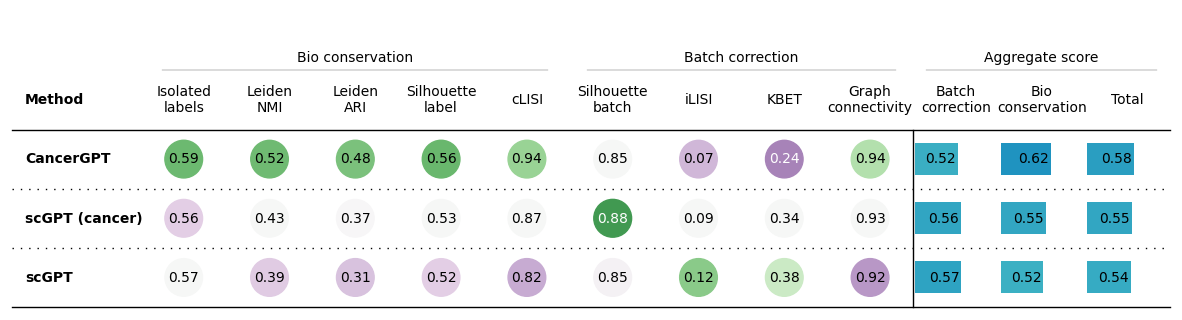

In [9]:
bm.plot_results_table(min_max_scale=False, save_dir="./figures")